In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.applications import DenseNet121, EfficientNetB0, ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


In [11]:
import os, shutil
from sklearn.model_selection import train_test_split

# Update this to your dataset root
original_data_dir = r"E:\Bone Fracture X-ray Dataset Simple vs. Comminuted Fractures\raw"
output_base_dir = r"E:\Bone Fracture X-ray Dataset Simple vs. Comminuted Fractures\dataset"

# Desired structure
splits = ['train', 'val', 'test']
split_ratios = [0.7, 0.15, 0.15]

# Make folders
classes = os.listdir(original_data_dir)
for split in splits:
    for cls in classes:
        os.makedirs(os.path.join(output_base_dir, split, cls), exist_ok=True)

# Split and copy files
for cls in classes:
    files = os.listdir(os.path.join(original_data_dir, cls))
    train_files, testval_files = train_test_split(files, test_size=0.3, random_state=42)
    val_files, test_files = train_test_split(testval_files, test_size=0.5, random_state=42)

    for split, file_list in zip(splits, [train_files, val_files, test_files]):
        for file in file_list:
            src = os.path.join(original_data_dir, cls, file)
            dst = os.path.join(output_base_dir, split, cls, file)
            shutil.copy2(src, dst)


In [9]:
import os

data_path = r"E:\Bone Fracture X-ray Dataset Simple vs. Comminuted Fractures\dataset"
print("Checking path:", path)
print("Path exists:", os.path.exists(path))


Checking path: E:\Bone Fracture X-ray Dataset Simple vs. Comminuted Fractures\dataset\train
Path exists: False


In [12]:
img_size = (224, 224)
batch_size = 32
#data_path = "E:\Bone Fracture X-ray Dataset Simple vs. Comminuted Fractures\dataset"  # UPDATE with your folder path

datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    os.path.join(data_path, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_gen = datagen.flow_from_directory(
    os.path.join(data_path, 'val'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_gen = datagen.flow_from_directory(
    os.path.join(data_path, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


Found 11242 images belonging to 2 classes.
Found 2409 images belonging to 2 classes.
Found 2410 images belonging to 2 classes.


In [31]:
class_labels = list(train_gen.class_indices.keys())
print("Class labels:", class_labels)


Class labels: ['Comminuted Bone Fracture', 'Simple Bone Fracture']


In [34]:
def build_custom_cnn():
    model = Sequential([
        Input(shape=(224, 224, 3)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model


In [35]:
def build_alexnet():
    model = Sequential([
        Input(shape=(224, 224, 3)),
        Conv2D(96, (11, 11), strides=4, activation='relu'),
        MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
        Conv2D(256, (5, 5), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
        Conv2D(384, (3, 3), padding='same', activation='relu'),
        Conv2D(384, (3, 3), padding='same', activation='relu'),
        Conv2D(256, (3, 3), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
        Flatten(),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model


In [36]:
def build_transfer_model(base_model_func):
    base_model = base_model_func(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)

    return Model(inputs=base_model.input, outputs=output)


In [37]:
def train_model(model, name):
    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    print(f"\nTraining {name}...")
    history = model.fit(train_gen, validation_data=val_gen, epochs=10, verbose=1)
    return model, history


In [38]:
def evaluate_model(model, name):
    test_gen.reset()
    preds = model.predict(test_gen)
    y_pred = (preds > 0.5).astype(int)
    y_true = test_gen.classes

    print(f"\n{name} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels,
                yticklabels=class_labels)
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()



Training CustomCNN...
Epoch 1/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 181s 511ms/step - accuracy: 0.5737 - loss: 0.7132 - val_accuracy: 0.6032 - val_loss: 0.6148
Epoch 2/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 170s 482ms/step - accuracy: 0.6573 - loss: 0.5868 - val_accuracy: 0.6990 - val_loss: 0.5641
Epoch 3/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 172s 488ms/step - accuracy: 0.6993 - loss: 0.5402 - val_accuracy: 0.7078 - val_loss: 0.5308
Epoch 4/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 169s 481ms/step - accuracy: 0.7562 - loss: 0.4845 - val_accuracy: 0.7443 - val_loss: 0.4869
Epoch 5/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 173s 491ms/step - accuracy: 0.7992 - loss: 0.4251 - val_accuracy: 0.7576 - val_loss: 0.4668
Epoch 6/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 170s 483ms/step - accuracy: 0.8394 - loss: 0.3707 - val_accuracy: 0.7775 - val_loss: 0.4514
Epoch 7/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 168s 477ms/step - accuracy: 0.8583 - loss: 0.3276 - val_accuracy: 0.7945 - val_loss: 0.4345
Epoch 8/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 167s 474ms/st

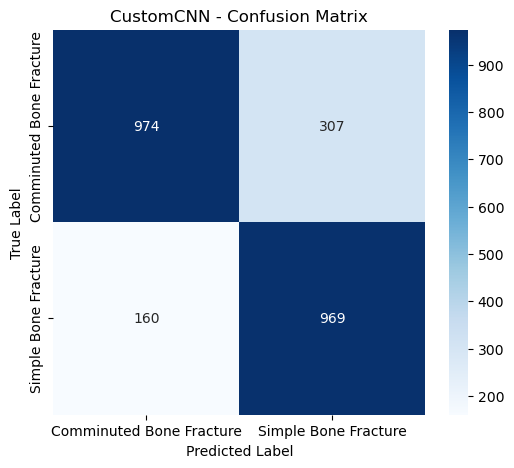


Training AlexNet...
Epoch 1/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 201s 568ms/step - accuracy: 0.5424 - loss: 0.6682 - val_accuracy: 0.6115 - val_loss: 0.6142
Epoch 2/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 201s 572ms/step - accuracy: 0.5931 - loss: 0.6195 - val_accuracy: 0.6164 - val_loss: 0.6043
Epoch 3/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 200s 569ms/step - accuracy: 0.6079 - loss: 0.6032 - val_accuracy: 0.6073 - val_loss: 0.6072
Epoch 4/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 199s 566ms/step - accuracy: 0.6204 - loss: 0.5970 - val_accuracy: 0.6243 - val_loss: 0.5950
Epoch 5/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 199s 566ms/step - accuracy: 0.6388 - loss: 0.5885 - val_accuracy: 0.6351 - val_loss: 0.5846
Epoch 6/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 200s 568ms/step - accuracy: 0.6668 - loss: 0.5655 - val_accuracy: 0.7036 - val_loss: 0.5348
Epoch 7/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 199s 566ms/step - accuracy: 0.7285 - loss: 0.5016 - val_accuracy: 0.7617 - val_loss: 0.4870
Epoch 8/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 200s 567ms/step

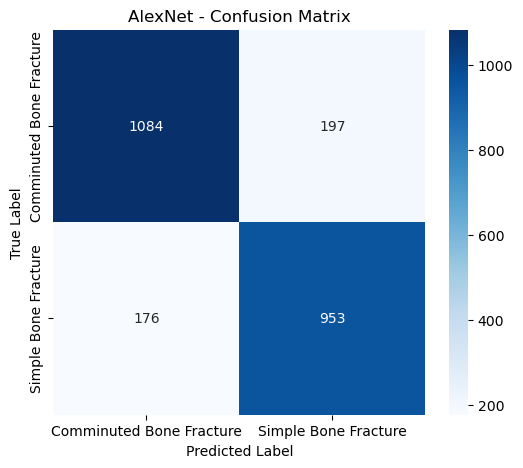


Training DenseNet121...
Epoch 1/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 284s 785ms/step - accuracy: 0.5724 - loss: 0.7311 - val_accuracy: 0.7397 - val_loss: 0.5413
Epoch 2/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 273s 775ms/step - accuracy: 0.7146 - loss: 0.5521 - val_accuracy: 0.7841 - val_loss: 0.4806
Epoch 3/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 273s 775ms/step - accuracy: 0.7547 - loss: 0.5044 - val_accuracy: 0.8024 - val_loss: 0.4418
Epoch 4/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 275s 782ms/step - accuracy: 0.7653 - loss: 0.4768 - val_accuracy: 0.8111 - val_loss: 0.4256
Epoch 5/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 272s 773ms/step - accuracy: 0.7924 - loss: 0.4418 - val_accuracy: 0.8331 - val_loss: 0.3879
Epoch 6/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 272s 773ms/step - accuracy: 0.8171 - loss: 0.4112 - val_accuracy: 0.8410 - val_loss: 0.3769
Epoch 7/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 269s 763ms/step - accuracy: 0.8168 - loss: 0.3971 - val_accuracy: 0.8597 - val_loss: 0.3509
Epoch 8/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 271s 769ms/

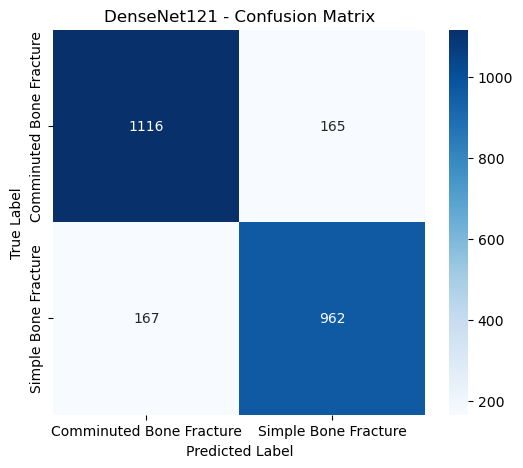


Training EfficientNetB0...
Epoch 1/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 182s 502ms/step - accuracy: 0.5080 - loss: 0.6993 - val_accuracy: 0.4682 - val_loss: 0.6937
Epoch 2/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 174s 494ms/step - accuracy: 0.5172 - loss: 0.6932 - val_accuracy: 0.5318 - val_loss: 0.6913
Epoch 3/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 174s 493ms/step - accuracy: 0.5391 - loss: 0.6908 - val_accuracy: 0.5318 - val_loss: 0.6913
Epoch 4/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 173s 491ms/step - accuracy: 0.5250 - loss: 0.6920 - val_accuracy: 0.5318 - val_loss: 0.6912
Epoch 5/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 173s 492ms/step - accuracy: 0.5308 - loss: 0.6917 - val_accuracy: 0.5318 - val_loss: 0.6912
Epoch 6/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 173s 492ms/step - accuracy: 0.5285 - loss: 0.6910 - val_accuracy: 0.5318 - val_loss: 0.6912
Epoch 7/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 174s 494ms/step - accuracy: 0.5254 - loss: 0.6922 - val_accuracy: 0.5318 - val_loss: 0.6911
Epoch 8/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 174s 493

c:\Users\Deepika Tak\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Deepika Tak\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Deepika Tak\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


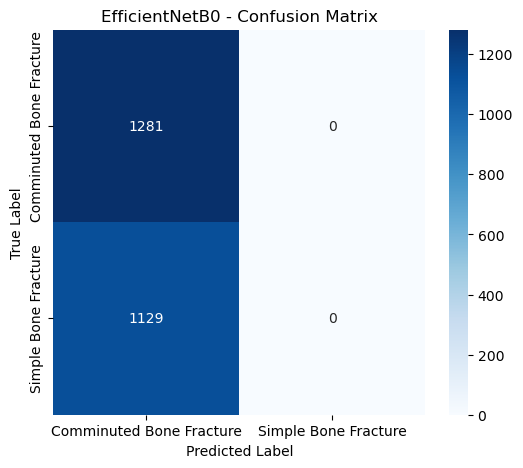


Training ResNet50...
Epoch 1/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 280s 784ms/step - accuracy: 0.5058 - loss: 0.7555 - val_accuracy: 0.5367 - val_loss: 0.6828
Epoch 2/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 273s 777ms/step - accuracy: 0.5295 - loss: 0.6871 - val_accuracy: 0.5529 - val_loss: 0.6799
Epoch 3/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 272s 772ms/step - accuracy: 0.5436 - loss: 0.6833 - val_accuracy: 0.5471 - val_loss: 0.6782
Epoch 4/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 277s 787ms/step - accuracy: 0.5513 - loss: 0.6790 - val_accuracy: 0.5513 - val_loss: 0.6775
Epoch 5/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 275s 781ms/step - accuracy: 0.5646 - loss: 0.6760 - val_accuracy: 0.5575 - val_loss: 0.6742
Epoch 6/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 274s 778ms/step - accuracy: 0.5488 - loss: 0.6770 - val_accuracy: 0.5749 - val_loss: 0.6749
Epoch 7/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 272s 774ms/step - accuracy: 0.5548 - loss: 0.6779 - val_accuracy: 0.5592 - val_loss: 0.6733
Epoch 8/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 275s 780ms/ste

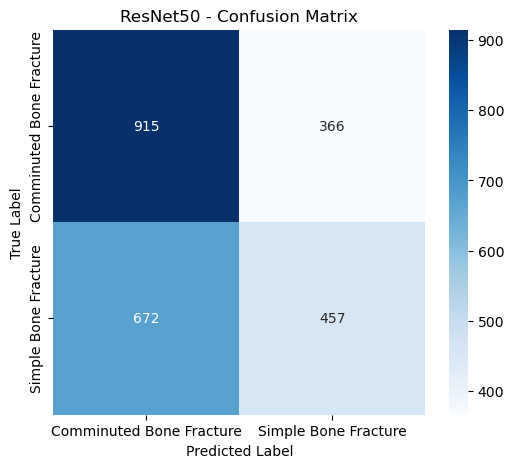

In [39]:
models = {
    'CustomCNN': build_custom_cnn(),
    'AlexNet': build_alexnet(),
    'DenseNet121': build_transfer_model(DenseNet121),
    'EfficientNetB0': build_transfer_model(EfficientNetB0),
    'ResNet50': build_transfer_model(ResNet50),
}

histories = {}
trained_models = {}

for name, model in models.items():
    trained_model, history = train_model(model, name)
    trained_models[name] = trained_model
    histories[name] = history
    evaluate_model(trained_model, name)


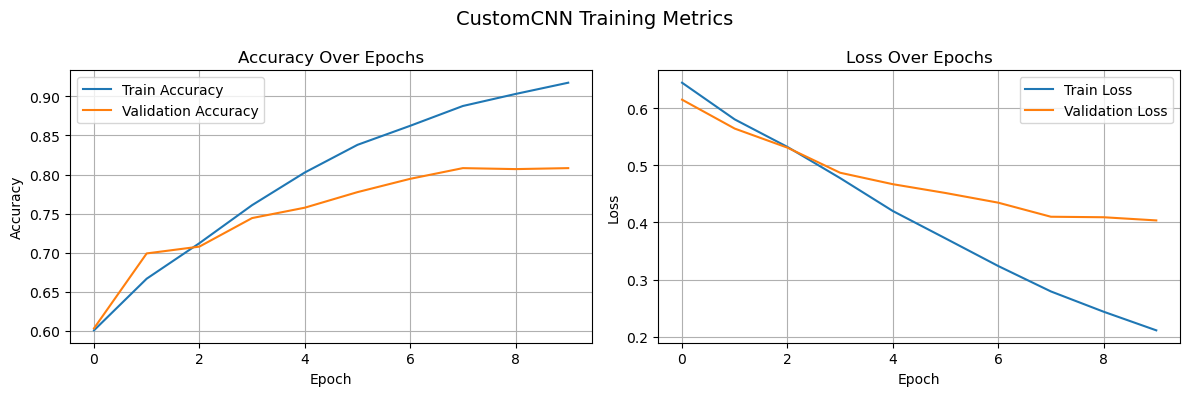

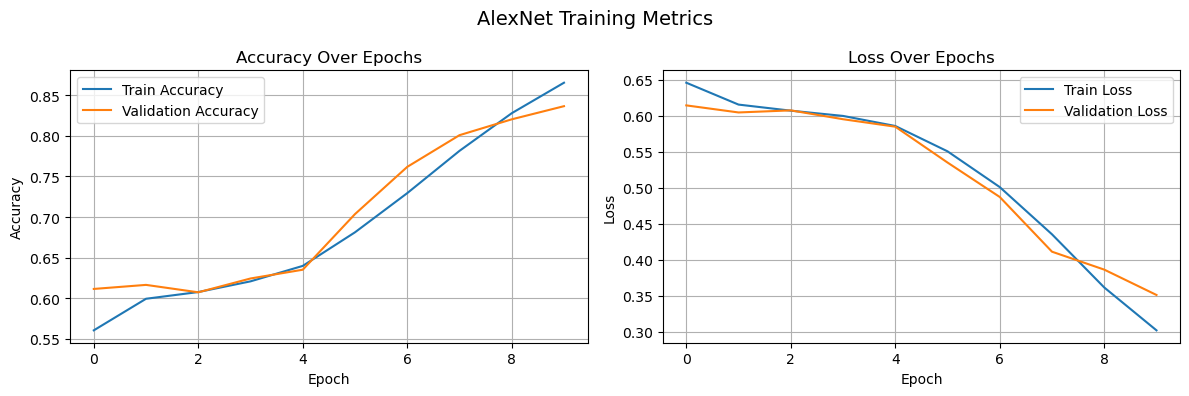

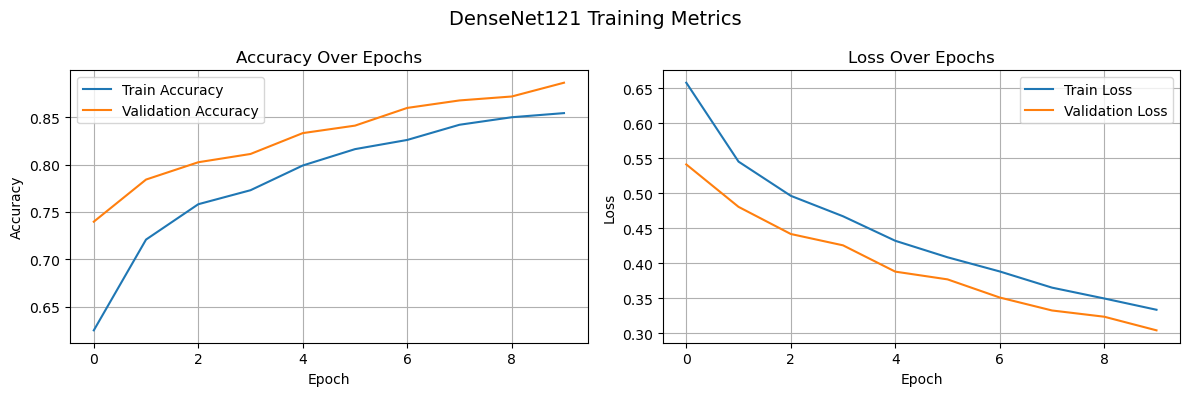

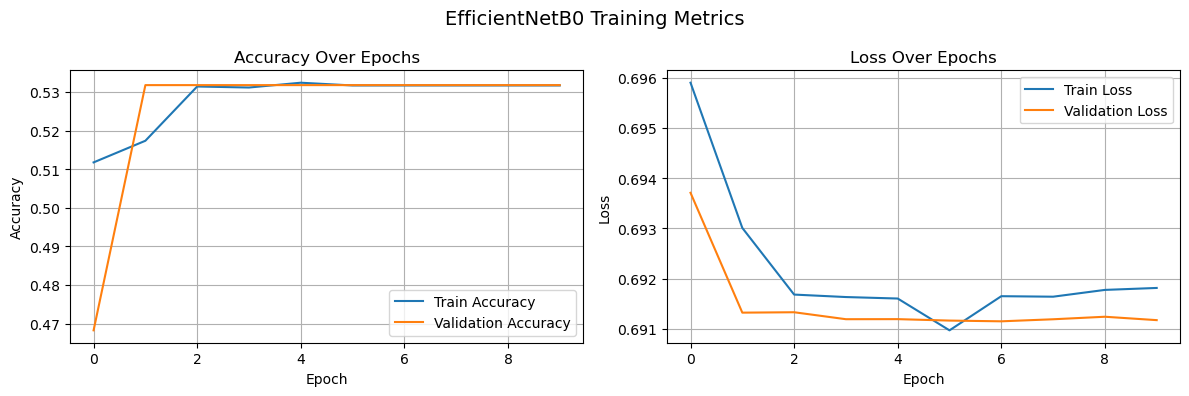

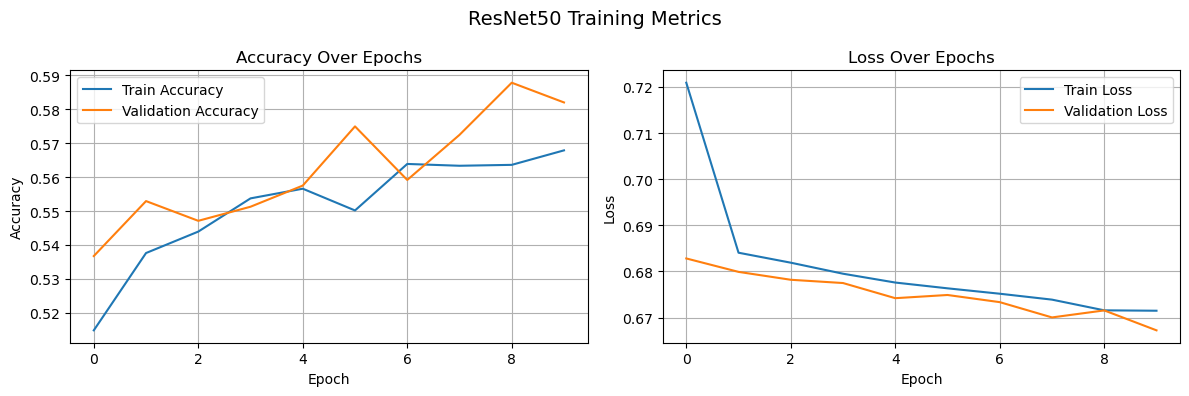

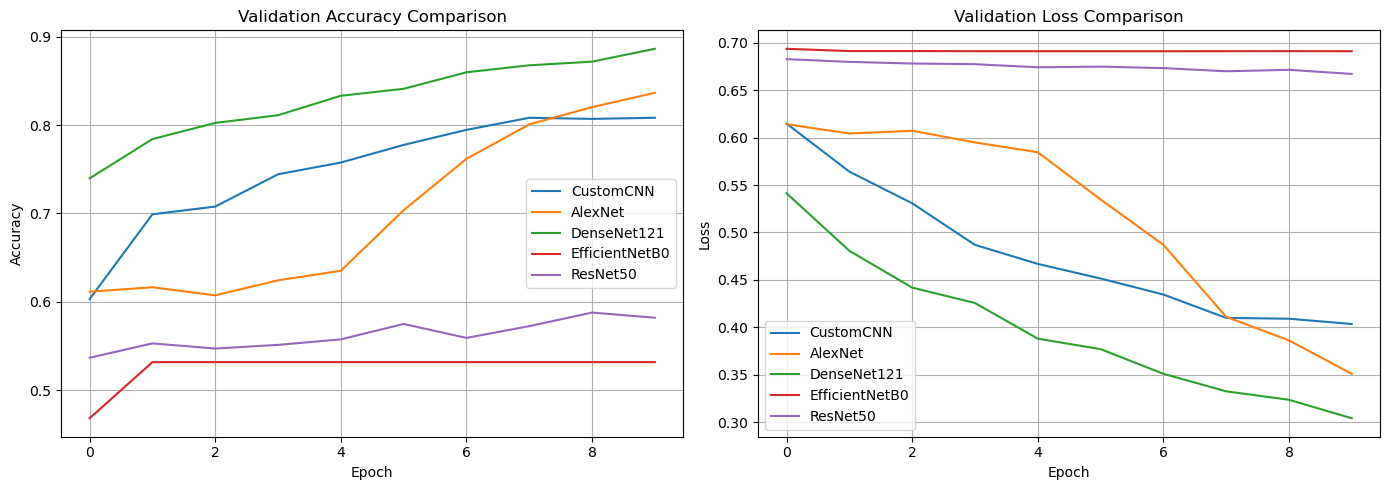

In [42]:
plot_histories(histories)
compare_models(histories)


In [43]:
def plot_histories(histories):
    for name, history in histories.items():
        plt.figure(figsize=(12, 4))
        plt.suptitle(f"{name} Training Metrics", fontsize=14)

        # Accuracy plot
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Accuracy Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

        # Loss plot
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Loss Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()


In [44]:
def compare_models(histories):
    plt.figure(figsize=(14, 5))

    # Validation Accuracy Comparison
    plt.subplot(1, 2, 1)
    for name, history in histories.items():
        plt.plot(history.history['val_accuracy'], label=name)
    plt.title('Validation Accuracy Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Validation Loss Comparison
    plt.subplot(1, 2, 2)
    for name, history in histories.items():
        plt.plot(history.history['val_loss'], label=name)
    plt.title('Validation Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [46]:
print_final_metrics(histories)



Final Validation Accuracy and Loss:
----------------------------------------
CustomCNN       | Accuracy: 0.8082 | Loss: 0.4034
AlexNet         | Accuracy: 0.8364 | Loss: 0.3509
DenseNet121     | Accuracy: 0.8863 | Loss: 0.3040
EfficientNetB0  | Accuracy: 0.5318 | Loss: 0.6912
ResNet50        | Accuracy: 0.5820 | Loss: 0.6672


In [47]:
def print_final_metrics(histories):
    print("\nFinal Validation Accuracy and Loss:")
    print("-" * 40)
    for name, history in histories.items():
        val_acc = history.history['val_accuracy'][-1]
        val_loss = history.history['val_loss'][-1]
        print(f"{name:<15} | Accuracy: {val_acc:.4f} | Loss: {val_loss:.4f}")


In [48]:
print_final_metrics(histories)



Final Validation Accuracy and Loss:
----------------------------------------
CustomCNN       | Accuracy: 0.8082 | Loss: 0.4034
AlexNet         | Accuracy: 0.8364 | Loss: 0.3509
DenseNet121     | Accuracy: 0.8863 | Loss: 0.3040
EfficientNetB0  | Accuracy: 0.5318 | Loss: 0.6912
ResNet50        | Accuracy: 0.5820 | Loss: 0.6672
